# Google Fit: Guide to data extraction and analysis

<img src='https://i.imgur.com/Oc6P36u.jpg' height="500"> 

A picture of the Google Fit Mobile Application

Google Fit is Google's version of Apple Health. It lets you track your fitness activity and health data from all of your wearable devices like Apple Watches, Samsung Galaxy Watches, Polar Smartwatches, etc. <br>

Google Fit is completely free. It also comes preloaded on Android Wear watches and can be downloaded from the Apple App and Google Play stores. <br>

We've been using the Google Fit application for the past few weeks and we will show you how to extract its data, visualize your activities and compute correlations between multiple metrics of the data. The Google Fit API allows the users to extract all kinds of data on workouts and medical health. However, for this notebook, we will be focusing on metrics of the participant's daily summary and activities such as steps, heart rate, workouts, etc.



We will be able to extract the following parameters:

Parameter Name  | Sampling Frequency 
-------------------|------------------
Sleep Duration |  Daily
Reproductive Health (Period Flow) |  Daily
Move Minutes|  Daily
Speed |  Daily
<b>Energy Expended</b> |  Daily
Blood Glucose      |  Per Minute 
Oxygen Saturation |  Per Minute 
<b>Steps</b> |  Per Minute 
Blood Pressure |  Per Minute 
Body Temperature |  Per Minute
Calories Consumed |  Per Minute
<b>Heart Rate</b> |  Every 5 seconds 
<b>Weight</b> | Daily

** These are all parameters that can be directly extracted individually

In this guide, we sequentially cover the following **nine** topics to extract data from Cronometer servers:

1. **Set up**<br>
2. **Authentication/Authorization**<br>
   - Requires only access_token, no OAuth.<br>
3. **Data extraction**<br>
  - We get data via wearipedia in a couple lines of code<br>
4. **Data Exporting**<br>
    - We export all of this data to file formats compatible by R, Excel, and MatLab.<br>
5. **Adherence**<br>
    - We simulate non-adherence by dynamically removing datapoints from our simulated data.<br>
6. **Visualization**<br>
    - We create a simple plot to visualize our data.<br>
7. **Advanced visualization**<br>
    - 7.1 Visualizing participant's Weekly Step Activity! <br>
    - 7.2 Visualizing participant's Weekly Heart Activity!<br>
    - 7.3 Visualizing participant's Detailed Heart Rate Breakdown!<br>
8. **Data Analysis**<br>
  - 8.1  Analyzing correlation between Heart Rate and Number of Steps! <br>
9. **Outlier Detection** <br>
  - 9.1 Highlighting Outliers!<br>

Disclaimer: this notebook is purely for educational purposes. All of the data currently stored in this notebook is purely *synthetic*, meaning randomly generated according to rules we created. Despite this, the end-to-end data extraction pipeline has been tested on our own data, meaning that if you enter your own email and password on your own Colab instance, you can visualize your own *real* data. That being said, we were unable to thoroughly test the timezone functionality, though, since we only have one account, so beware.

Before starting, note that the Google Fit access token necessary to extract data only lasts for 1 hour. Thus, the researcher should fetch the data as soon as the participant provides the token.


# 1. Setup

## Participant Setup

Dear Participant,

Once you download the Google Fit app, please set it up by following these resources:
- Written guide: https://www.businessinsider.com/guides/tech/google-fit
- Video guide: https://www.youtube.com/watch?v=0GnBgqnRM60&ab_channel=UponTop

Make sure that your phone is logged to the google fit app using the Google Fit login credentials (email and password) given to you by the data receiver.

Best,

Wearipedia

## Data Receiver Setup

Please follow the below steps:

1. Create an email address for the participant, for example `foo@email.com`.
2. Create a google fit account with the email `foo@email.com` and some random password.
3. Keep `foo@email.com` and password stored somewhere safe.
4. Distribute the device to the participant and instruct them to follow the participant setup letter above.
5. Go to this link: https://developers.google.com/oauthplayground/
6. Choose fitness API v1 in the Select & authorize APIs menu
<br>
<img src='https://i.imgur.com/odrvr9v.png' width="500" height="550"> 
7. Select all the different datatypes that you the researcher wants you to grant access to and click authorize APIs. Your clinical study coordinator might have more details regarding what sorts of health data they require. <br>
<img src='https://i.imgur.com/L5PM8lB.png' width="450" height="550"> 
8. Login with your account (the one the participant has connected with their Google Fit Account). <br>
<img src='https://i.imgur.com/LEY8CnQ.png' width="400" height="500"> 
9. Click on ‘Continue’ 
<br>
<img src="https://i.imgur.com/RLUtPeu.png" height="500" width="300">
10. Click on the exchange authorization code for tokens in Step2.
<br>
<img src="https://i.imgur.com/9KpZbJZ.png">
11. Copy and paste the access token from the Google Developer Playground and paste in the box in part section **2.1**. <br>
<img src="https://i.imgur.com/Gv7PRGI.png">
12. Install the `wearipedia` Python package to easily extract data from this device via the Cronometer API.


In [2]:
!pip install wearipedia
!pip install openpyxl

# 2. Authentication/Authorization

To obtain access to data, authorization is required. All you'll need to do here is just put in your access token for your Google Fit account. We'll use this username and password to extract the data in the sections below.

Google Fit uses external devices to extract recorded activities, but it requires the participant to provide access tokens to access Google's API and read fitness data from their account.

In [3]:
#@title Enter the Participant's Access Token

google_auth_code = '4/0AVHEtk5zeKpZ1vH0v8iVBoxK9BFrG3k72Y7Ce61mEv_kDi7e5uzm2CmS8incOAbP8pXbvQ' #@param {type:"string"}
google_access_token = 'ya29.a0Ael9sCO_HuqZGAgii5Z5EqFQ0_GxI1D3vQsj5g1TGZsRsnY-s4FuaVWB8sB28uxTrYvJIAAAEpp4oJSSiYmYVMmC8jiIxm2FxgE6hyQQgijoe0JZVAhLg1FzmE8oODAZm1t3DvHVA9QxIta_NFZ4RnbjF0R8aCgYKAR8SARESFQF4udJhOejZSWJt-DccLKr94OaP5A0163'
print('Authorization Code: '+google_auth_code)

Authorization Code: 4/0AVHEtk5zeKpZ1vH0v8iVBoxK9BFrG3k72Y7Ce61mEv_kDi7e5uzm2CmS8incOAbP8pXbvQ


# 3. Data Extraction

Data can be extracted via [wearipedia](https://github.com/Stanford-Health/wearipedia/), our open-source Python package that unifies dozens of complex wearable device APIs into one simple, common interface.

First, we'll set a date range and then extract all of the data within that date range. You can select whether you would like synthetic data or not with the checkbox.

In [4]:
#@title Enter start and end dates (in the format yyyy-mm-dd)

#set start and end dates - this will give you all the data from 2000-01-01 (January 1st, 2000) to 2100-02-03 (February 3rd, 2100), for example
start_date='2022-03-01' #@param {type:"string"}
end_date='2022-04-17' #@param {type:"string"}
synthetic = True #@param {type:"boolean"}

In [5]:
import wearipedia

device = wearipedia.get_device("google/googlefit")

if not synthetic:
    device.authenticate({"authorization_code": google_auth_code})

params = {"start_date": start_date, "end_date": end_date}

steps = device.get_data("steps", params=params)
heart_rate = device.get_data("heart_rate", params=params)
sleep = device.get_data("sleep", params=params)
heart_minutes = device.get_data("heart_minutes", params=params)
blood_pressure = device.get_data("blood_pressure", params=params)
blood_glucose = device.get_data("blood_glucose", params=params)
body_temperature = device.get_data("body_temperature", params=params)
calories_expended = device.get_data("calories_expended", params=params)
activity_minutes = device.get_data("activity_minutes", params=params)
height = device.get_data("height", params=params)
oxygen_saturation = device.get_data("oxygen_saturation", params=params)
menstruation = device.get_data("menstruation", params=params)
speed = device.get_data("speed", params=params)
weight = device.get_data("weight", params=params)
distance = device.get_data("distance", params=params)

# 4. Data Exporting

In this section, we export all of this data to formats compatible with popular scientific computing software (R, Excel, Google Sheets, Matlab). Specifically, we will first export to JSON, which can be read by R and Matlab. Then, we will export to CSV, which can be consumed by Excel, Google Sheets, and every other popular programming language.

## Exporting to JSON (R, Matlab, etc.)

Exporting to JSON is fairly simple. We export each datatype separately and also export a complete version that includes all simultaneously.

In [6]:
import json


json.dump(steps, open("steps.json", "w"))
json.dump(heart_rate, open("heart_rate.json", "w"))
json.dump(sleep, open("sleep.json", "w"))
json.dump(heart_minutes, open("heart_minutes.json", "w"))
json.dump(blood_pressure, open("blood_pressure.json", "w"))
json.dump(blood_glucose, open("blood_glucose.json", "w"))
json.dump(body_temperature, open("body_temperature.json", "w"))
json.dump(calories_expended, open("calories_expended.json", "w"))
json.dump(activity_minutes, open("activity_minutes.json", "w"))
json.dump(oxygen_saturation, open("oxygen_saturation.json", "w"))
json.dump(height, open("height.json", "w"))
json.dump(menstruation, open("menstruation.json", "w"))
json.dump(speed, open("speed.json", "w"))
json.dump(weight, open("weight.json", "w"))
json.dump(distance, open("distance.json", "w"))

complete = {
    "steps": steps,
    "heart_rate": heart_rate,
    "sleep": sleep,
    "heart_minutes": heart_minutes,
    "blood_pressure": blood_pressure,
    "blood_glucose": blood_glucose,
    "body_temperature": body_temperature,
    "calories_expended": calories_expended,
    "activity_minutes": activity_minutes,
    "oxygen_saturation": oxygen_saturation,
    "height": height,
    "menstruation": menstruation,
    "speed": speed,
    "weight": weight,
    "distance": distance,
}

json.dump(complete, open("complete.json", "w"))

Feel free to open the file viewer (see left pane) to look at the outputs!

## Exporting to CSV and XLSX (Excel, Google Sheets, R, Matlab, etc.)

Exporting to CSV/XLSX requires a bit more processing, since they enforce a pretty restrictive schema.

We will thus export steps, heart rates, and breath rates all as separate files.

In [7]:
import pandas as pd

steps_df = pd.DataFrame.from_dict(steps)
steps_df.to_csv('steps.csv')
steps_df.to_excel('steps.xlsx')

heart_rate_df = pd.DataFrame.from_dict(heart_rate)
heart_rate_df.to_csv('heart_rate.csv')
heart_rate_df.to_excel('heart_rate.xlsx')

sleep_df = pd.DataFrame.from_dict(sleep)
sleep_df.to_csv('sleep.csv')
sleep_df.to_excel('sleep.xlsx')

heart_minutes_df = pd.DataFrame.from_dict(heart_minutes)
heart_minutes_df.to_csv('heart_minutes.csv')
heart_minutes_df.to_excel('heart_minutes.xlsx')

blood_pressure_df = pd.DataFrame.from_dict(blood_pressure)
blood_pressure_df.to_csv('blood_pressure.csv')
blood_pressure_df.to_excel('blood_pressure.xlsx')

blood_glucose_df = pd.DataFrame.from_dict(blood_glucose)
blood_glucose_df.to_csv('blood_glucose.csv')
blood_glucose_df.to_excel('blood_glucose.xlsx')

body_temperature_df = pd.DataFrame.from_dict(body_temperature)
body_temperature_df.to_csv('body_temperature.csv')
body_temperature_df.to_excel('body_temperature.xlsx')

calories_expended_df = pd.DataFrame.from_dict(calories_expended)
calories_expended_df.to_csv('calories_expended.csv')
calories_expended_df.to_excel('calories_expended.xlsx')

activity_minutes_df = pd.DataFrame.from_dict(activity_minutes)
activity_minutes_df.to_csv('activity_minutes.csv')
activity_minutes_df.to_excel('activity_minutes.xlsx')

oxygen_saturation_df = pd.DataFrame.from_dict(oxygen_saturation)
oxygen_saturation_df.to_csv('oxygen_saturation.csv')
oxygen_saturation_df.to_excel('oxygen_saturation.xlsx')

height_df = pd.DataFrame.from_dict(height)
height_df.to_csv('height.csv')
height_df.to_excel('height.xlsx')

mensuration_df = pd.DataFrame.from_dict(menstruation)
mensuration_df.to_csv('mensuration.csv')
mensuration_df.to_excel('mensuration.xlsx')

speed_df = pd.DataFrame.from_dict(speed)
speed_df.to_csv('speed.csv')
speed_df.to_excel('speed.xlsx')

weight_df = pd.DataFrame.from_dict(weight)
weight_df.to_csv('weight.csv')
weight_df.to_excel('weight.xlsx')

distance_df = pd.DataFrame.from_dict(distance)
distance_df.to_csv('distance.csv')
distance_df.to_excel('distance.xlsx')

Again, feel free to look at the output files and download them.

# 5. Adherence

The device simulator already automatically randomly deletes small chunks of the day. In this section, we will simulate non-adherence over longer periods of time from the participant (day-level and week-level).

Then, we will detect this non-adherence and give a Pandas DataFrame that concisely describes when the participant has had their device on and off throughout the entirety of the time period, allowing you to calculate how long they've had it on/off etc.

We will first delete a certain % of blocks either at the day level or week level, with user input.

In [12]:
#@title Non-adherence simulation
block_level = "day" #@param ["day", "week"]
adherence_percent = 0.89 #@param {type:"slider", min:0, max:1, step:0.01}

In [13]:
import numpy as np

if block_level == "day":
    block_length = 1
elif block_level == "week":
    block_length = 7

# This function will randomly remove datapoints from the 
# data we have recieved from Cronometer based on the
# adherence_percent

def AdherenceSimulator(data):

  num_blocks = len(data) // block_length
  num_blocks_to_keep = int(adherence_percent * num_blocks)
  idxes = np.random.choice(np.arange(num_blocks), replace=False, 
  size=num_blocks_to_keep)

  adhered_data = []

  for i in range(len(data)):
      if i in idxes:
          start = i * block_length
          end = (i + 1) * block_length
          for j in range(i,i+1):
            adhered_data.append(data[j])
  
  return adhered_data


# Adding adherence for all our datapoints
steps = AdherenceSimulator(steps)
heart_rate = AdherenceSimulator(heart_rate)
sleep = AdherenceSimulator(sleep)
heart_minutes = AdherenceSimulator(heart_minutes)
blood_pressure = AdherenceSimulator(blood_pressure)
blood_glucose = AdherenceSimulator(blood_glucose)
body_temperature = AdherenceSimulator(body_temperature)
calories_expended = AdherenceSimulator(calories_expended)
activity_minutes = AdherenceSimulator(activity_minutes)
oxygen_saturation = AdherenceSimulator(oxygen_saturation)
height = AdherenceSimulator(height)
menstruation = AdherenceSimulator(menstruation)
speed = AdherenceSimulator(speed)
weight = AdherenceSimulator(weight)
distance = AdherenceSimulator(distance)


And now we have significantly fewer datapoints! This will give us a more realistic situation, where participants may take off their device for days or weeks at a time.

Now let's detect non-adherence. We will return a Pandas DataFrame sampled at every day.

In [14]:
steps_df = pd.DataFrame.from_dict(steps)
heart_rate_df = pd.DataFrame.from_dict(heart_rate)
sleep_df = pd.DataFrame.from_dict(sleep)
heart_minutes_df = pd.DataFrame.from_dict(heart_minutes)
blood_pressure_df = pd.DataFrame.from_dict(blood_pressure)
blood_glucose_df = pd.DataFrame.from_dict(blood_glucose)
body_temperature_df = pd.DataFrame.from_dict(body_temperature)
calories_expended_df = pd.DataFrame.from_dict(calories_expended)
activity_minutes_df = pd.DataFrame.from_dict(activity_minutes)
oxygen_saturation_df = pd.DataFrame.from_dict(oxygen_saturation)
height_df = pd.DataFrame.from_dict(height)
mensuration_df = pd.DataFrame.from_dict(menstruation)
speed_df = pd.DataFrame.from_dict(speed)
weight_df = pd.DataFrame.from_dict(weight)
distance_df = pd.DataFrame.from_dict(distance)

We can plot this out, and we get adherence at one-day frequency throughout the entirety of the data collection period. For this chart we will plot WEIGHT change over the time period from the weight dataframe.

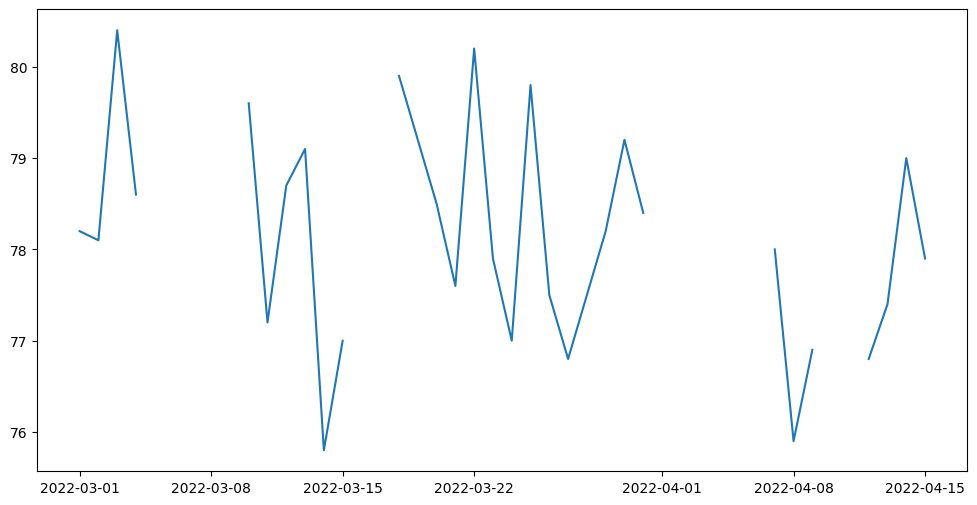

In [26]:
import matplotlib.pyplot as plt
import datetime

dates = pd.date_range(start_date,end_date)

energy = []

def datacleanup(dataset):
    
    df = pd.DataFrame()
    
    for i in range(len(dataset)):
        milliseconds = dataset.iloc[i].get(0)['startTimeMillis']
        date = datetime.datetime.fromtimestamp(milliseconds/1000.0)
        try:
            df = pd.concat([df,pd.DataFrame.from_dict([{
                'date':str(date)[:10],
                'value':dataset.iloc[i].get(0)['dataset'][0]['point'][0]['value'][0]['fpVal']
            }])])
        except:
            
            df = pd.concat([df,pd.DataFrame.from_dict([{
                'date':str(date)[:10],
                'value':None
            }])])
        
    return df

weights = datacleanup(weight_df)

for d in dates:
    res = weights[weights.get('date')==str(d)[:10]]
    if len(res) == 0:
        energy.append(None)
    else:
        energy.append(res.iloc[0].value)

plt.figure(figsize=(12, 6))
plt.plot(dates, energy)
plt.show()

## 6. Visualization

We've extracted lots of data, but what does it look like?

In this section, we will be visualizing our three kinds of data in a simple, customizable plot! This plot is intended to provide a starter example for plotting, whereas later examples emphasize deep control and aesthetics.

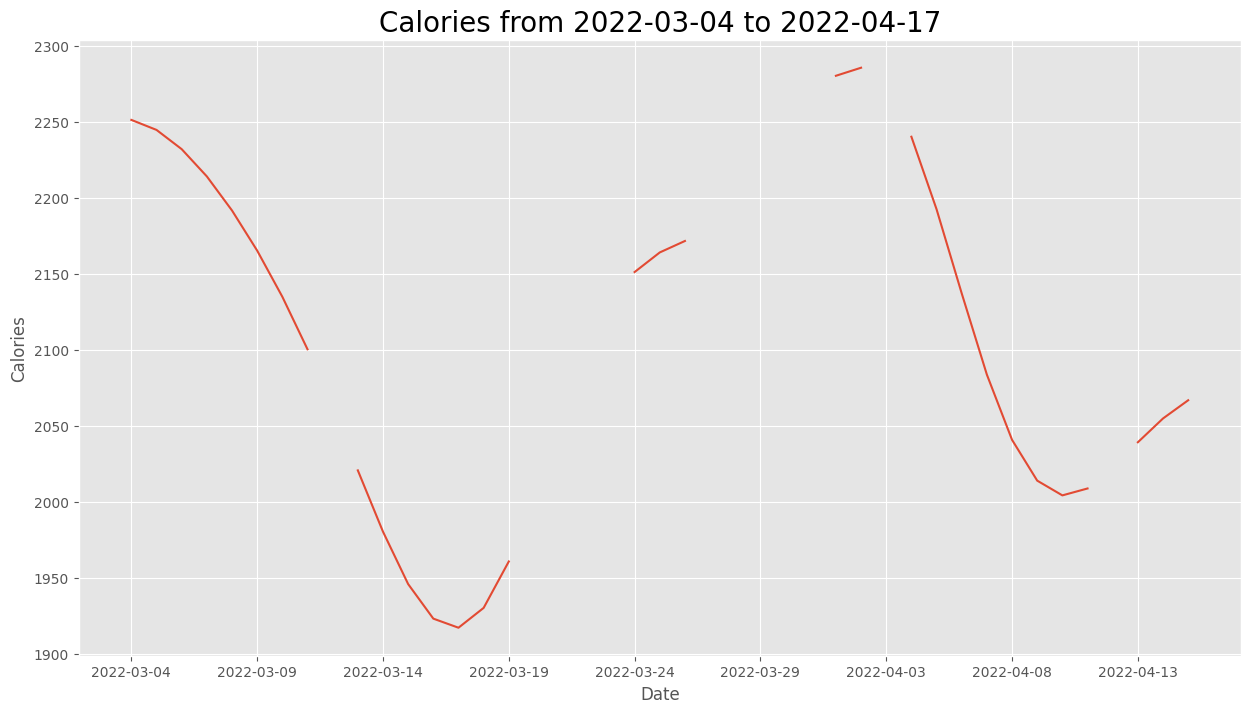

In [27]:
#@title Basic Plot
feature = "Calories Expended" #@param ['Heart Minutes', 'Calories Expended']
start_date = "2022-03-04" #@param {type:"date"}
time_interval = "full time" #@param ["one week", "full time"]
smoothness = 0.02 #@param {type:"slider", min:0, max:1, step:0.01}
smooth_plot = True #@param {type:"boolean"}

import matplotlib.dates as mdates
import matplotlib.pyplot as plt

start_date = datetime.datetime.strptime(start_date, '%Y-%m-%d')

if time_interval == "one week":
    day_idxes = [i for i,d in enumerate(dates) if d >= start_date and d <= start_date + timedelta(days=7)]
    end_date = start_date + timedelta(days=7)
elif time_interval == "full time":
    day_idxes = [i for i,d in enumerate(dates) if d >= start_date]
    end_date = dates[-1]

if feature == "Heart Minutes":
    hm = datacleanup(heart_minutes_df)
    concat_hm = []
    for i,d in enumerate(dates):
        day = d.strftime('%Y-%m-%d')
        if i in day_idxes:
          heart = hm[hm['date']==day]
          if len(heart) != 0:
              concat_hm += [(day,heart.iloc[0].value)]
          else:
              concat_hm += [(day,None)]
    ts = [x[0] for x in concat_hm]
    day_arr = [x[1] for x in concat_hm]
    sigma = 200 * smoothness
    title_fillin = "Calories"
  
if feature == "Calories Expended":
    ce = datacleanup(calories_expended_df)
    concat_data = []
    for i,d in enumerate(dates):
        day = d.strftime('%Y-%m-%d')
        if i in day_idxes:
          cals = ce[ce['date']==day]
          if len(cals) != 0:
              concat_data += [(day,cals.iloc[0].value)]
          else:
              concat_data += [(day,None)]
    ts = [x[0] for x in concat_data]
    day_arr = [x[1] for x in concat_data]
    sigma = 200 * smoothness
    title_fillin = "Calories"

with plt.style.context('ggplot'):
    fig, ax = plt.subplots(figsize=(15, 8))
    if smooth_plot:
        def to_numpy(day_arr):
            arr_nonone = [x for x in day_arr if x is not None]
            mean_val = int(np.mean(arr_nonone))
            for i,x in enumerate(day_arr):
                if x is None:
                    day_arr[i] = mean_val

            return np.array(day_arr)

        none_idxes = [i for i,x in enumerate(day_arr) if x is None]
        day_arr = to_numpy(day_arr)
        from scipy.ndimage import gaussian_filter
        day_arr = list(gaussian_filter(day_arr, sigma=sigma))
        for i, x in enumerate(day_arr):
            if i in none_idxes:
                day_arr[i] = None

    plt.plot(ts, day_arr)
    start_date_str = start_date.strftime('%Y-%m-%d')
    end_date_str = end_date.strftime('%Y-%m-%d')
    plt.title(f"{title_fillin} from {start_date_str} to {end_date_str}",
              fontsize=20)
    plt.xlabel("Date")
    plt.xticks(ts[::int(len(ts)/8)])
    plt.ylabel(title_fillin)

This plot allows you to quickly scan your data at many different time scales (week and full) and for different kinds of measurements (heart rate and weight), which enables easy and fast data exploration.

Furthermore, the smoothness parameter makes it easy to look for patterns in long-term trends.

# 7. Advanced Visualization

Now we'll do some more advanced plotting that at times features hardcore matplotlib hacking with the benefit of aesthetic quality.

## 7.1 Visualizing participant's Weekly Step Activity!

Let's say you were interested in knowing how many steps you take in a day. If you had an iPhone you could go onto Apple Health and check out your step count that is being approximated by just your iphone's [built-in accelerometer](https://developer.apple.com/documentation/coremotion/getting_raw_accelerometer_events). You would see your Weekly Steps chart using the following plot: <br>
<img src="https://i.imgur.com/gG8EbwJ.jpg" height="300"> <br>
Let's recreate this for the your choice of week using the data that we have fetched from the Google Api!


Below, input the desired start and end dates for the plot above.


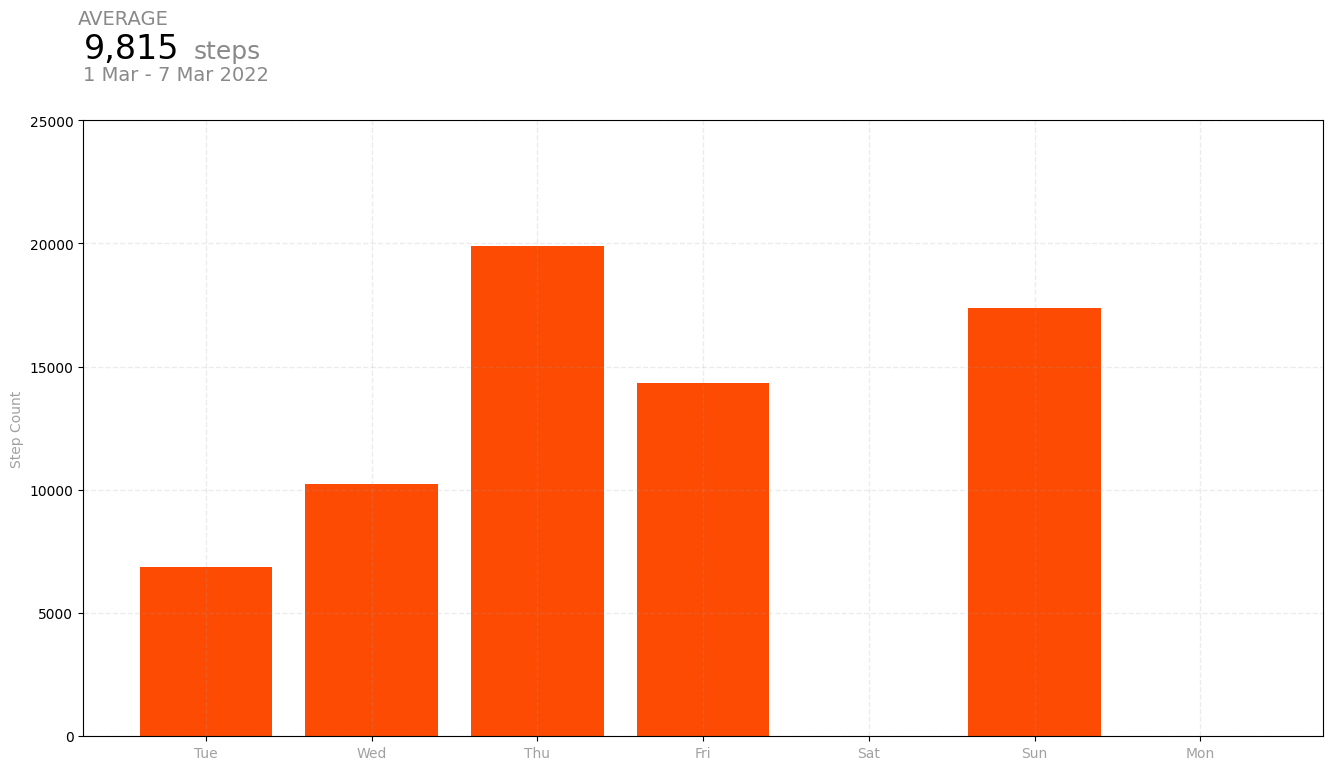

In [28]:
#@title Set date range for the chart above

start = "2022-03-01" #@param {type:"date"}
end = "2022-03-07" #@param {type:"date"}

from datetime import  date

# A Dictionary to save the list of all the dates between end and start dates
step_plot_dates= {}

# Saving the end and start dates in a date format from the inputted strings
step_plot_start_date = date(int(start.split('-')[0]),int(start.split('-')[1]),
                            int(start.split('-')[2]))
step_plot_end_date = date(int(end.split('-')[0]),int(end.split('-')[1]),
                          int(end.split('-')[2]))

# Finding the list of all dates between our start and end dates
dates = list(pd.date_range(step_plot_start_date,step_plot_end_date,freq='d'))

# Dictionary to store the stepcount for each date
stepcount = {}

def datacleanup(dataset):
    
    df = pd.DataFrame()
    
    for i in range(len(dataset)):
        milliseconds = dataset.iloc[i].get(0)['startTimeMillis']
        date = datetime.datetime.fromtimestamp(milliseconds/1000.0)
        try:
            df = pd.concat([df,pd.DataFrame.from_dict([{
                'date':str(date)[:10],
                'value':dataset.iloc[i].get(0)['dataset'][0]['point'][0]['value'][0]['intVal']
            }])])
        except:
            
            df = pd.concat([df,pd.DataFrame.from_dict([{
                'date':str(date)[:10],
                'value':None
            }])])
        
    return df

steps_cleaned = datacleanup(steps_df)
stepcount = {}

# Loop to go over each date in our list
for date_val in dates:
    # Initializing each date in our dictionary as 0
    stepcount[date_val.day_name()[:3]+" ("+
            date_val.to_pydatetime().strftime('%Y-%m-%d')+")"] = 0
    d = str(date_val)[:10]
    res = steps_cleaned[steps_cleaned.date == d] 
    if len(res) > 0:
        stepcount[date_val.day_name()[:3]+" ("+
            date_val.to_pydatetime().strftime('%Y-%m-%d')+")"] = res.iloc[0].value
# Counts the average steps in our plot and stores that as a formatted text
average_steps = '{:,}'.format(int(np.mean(list(stepcount.values()))))

# Saving the plot date range in the form of a string
date_range_text = (str(step_plot_start_date.day)+' '+
step_plot_start_date.strftime("%B")[:3]+' - '+
 str(step_plot_end_date.day)+' '+step_plot_end_date.strftime("%B")[:3]+
 ' '+ step_plot_start_date.strftime("%Y"))

# Creating the matptplotlib graph
plt1 = plt.figure(figsize=(16,8))
ax = plt1.gca()

# Adding grid lines to the chart
plt.grid(color="#a1a1a1", linestyle='--', linewidth=1, alpha = 0.2)

# Plotting our bars
plt.bar([key[:3] for key in stepcount.keys()],list(stepcount.values()),
        color="#FD4B03")

# Setting labels and titles
plt.ylabel("Step Count",color="#a1a1a1")

# Adding Step header
plt.text(0.15,1,"AVERAGE",fontsize=14,color='#89898B',
         transform=plt1.transFigure,horizontalalignment='center',
         weight='light')
plt.text(0.155,0.957,average_steps,fontsize=24,transform=plt1.transFigure,
         horizontalalignment='center')
plt.text(0.215,0.957,'steps',fontsize=18,transform=plt1.transFigure,
         horizontalalignment='center',color='#89898B')
plt.text(0.183,0.93,date_range_text,fontsize=14,color='#89898B',
        transform=plt1.transFigure, horizontalalignment='center', weight='light')


# Setting x and y ticks
plt.yticks([0,5000,10000,15000,20000,25000])
plt.xticks(color="#a1a1a1")

plt.show()

<i>Above is a plot we created ourselves!</i>

## 7.2 Visualizing participant's Weekly Heart Activity!

Similar to 7.1, if you were interested in checking out your heart rate values over the week then Apple Health would show your Weekly Heart Rate chart using the following plot: <br>
<img src="https://i.imgur.com/hS9Q9uP.jpg" height="600"> <br>
Let's recreate this for the your choice of week using the data that we have fetched from the Google Api! <br>

First, we will save the data that we fetched from the Google Fit API in the form of a DataFrame for us to easily work with that data!


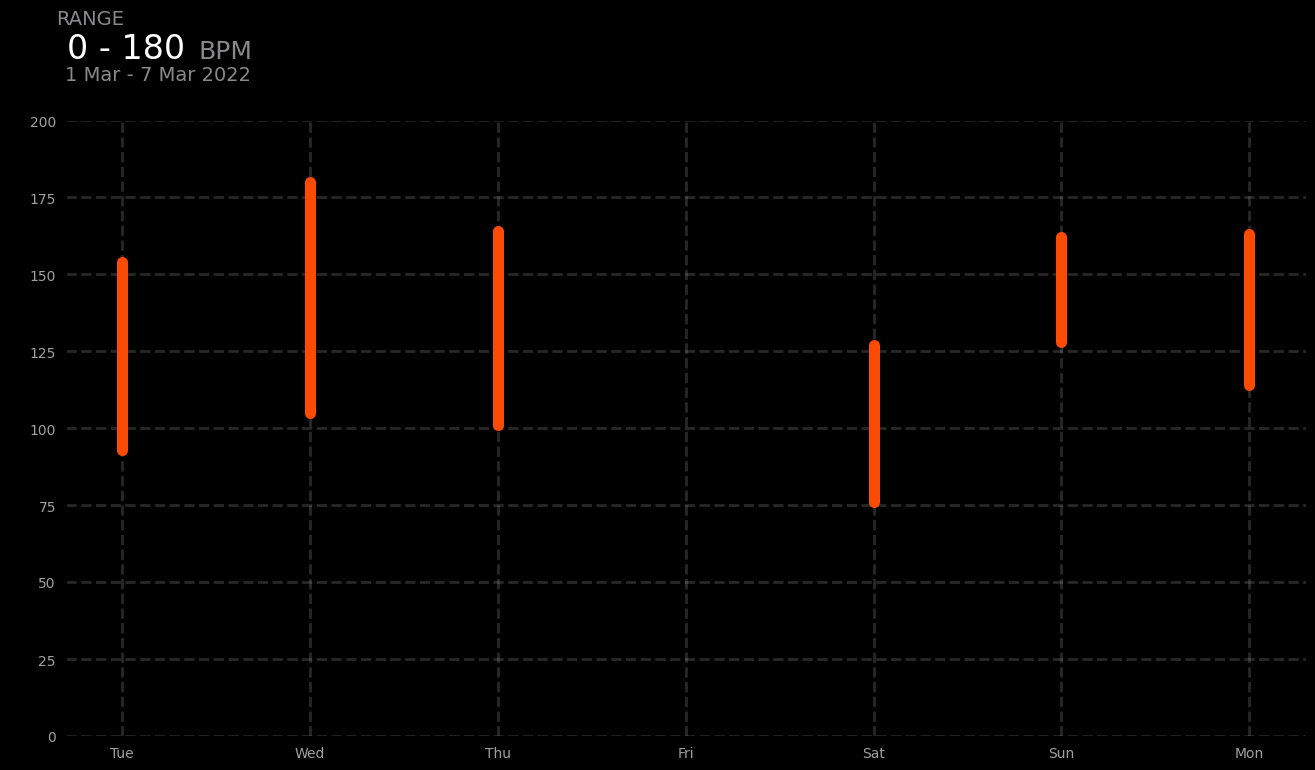

In [29]:
# Creating a dictionary to save all the heart rate values with the dates
heartrate_dict = {}

# Traversing through each entry in our DataFrame to save heart
# rate values for each date
for i in range(heart_rate_df.size-1):
    # Case when there is no data for a specific date
    try:
        heartrate_dict[datetime.datetime.fromtimestamp(
        int(heart_rate_df.iloc[i].get(0)['startTimeMillis'])// 1000).strftime(
            '%Y-%m-%d')] = (
        int(np.ceil(heart_rate_df.iloc[i].get(0)['dataset'][0]['point'][0]['value'][0]['fpVal'])),
        int(np.ceil(heart_rate_df.iloc[i].get(0)['dataset'][0]['point'][0]['value'][1]['fpVal'])),
        int(np.ceil(heart_rate_df.iloc[i].get(0)['dataset'][0]['point'][0]['value'][2]['fpVal'])))
    except:
        continue
# Creating a dictionary to save all the heart rate values with the dates between the specific end and start dates
heartrate_dict_weekly = {}

# Traversing each date for all the dates between start and end
for date_val in dates:
  # Initilizing each date with (0,0,0) 
  heartrate_dict_weekly[date_val.day_name()[:3]+" ("+
                  date_val.to_pydatetime().strftime('%Y-%m-%d')+")"] = (0,0,0)
  # Saving actual high, low and avg values for dates that have data avaliable
  for key in heartrate_dict.keys():
    if (date_val.to_pydatetime().strftime('%Y-%m-%d') == key):
      heartrate_dict_weekly[date_val.day_name()[:3]+" ("+
      date_val.to_pydatetime().strftime('%Y-%m-%d')+")"] = heartrate_dict[key]

# This will help us find the low to max heart rate values for our chart header
bpm_range = str(min([i[2] for i in heartrate_dict_weekly.values()]))+' - '+ str(max([i[1] for i in heartrate_dict_weekly.values()]))

# Initializing the figure
plt2 = plt.figure(figsize=(16,8),facecolor='black')
ax = plt.gca()
ax.set_facecolor('#000000')


# Plotting the values
x = [key[:3] for key in list(heartrate_dict_weekly.keys())]
y = list(heartrate_dict_weekly.values())
plt.plot((range(len(x)),range(len(x))),([i[1] for i in y], [i[2] for i in y]),
         c='#FD4B03',lw=8,solid_capstyle='round')

# Setting y limit to the chart
plt.ylim(0,200)

# Setting x and y ticks
plt.xticks(range(len(x)),x,color="#a1a1a1")
plt.yticks(color="#a1a1a1")

# Setting labels
plt.ylabel('Heart Rate')

# Creating grid lines
plt.grid(color="#a1a1a1", linestyle='--', linewidth=2, alpha = 0.25)


# Adding Heart header
plt.text(0.14,1,"RANGE",fontsize=14,color='#89898B',transform=plt2.transFigure,
         horizontalalignment='center', weight='light')
plt.text(0.1625,0.957,bpm_range,fontsize=24,transform=plt2.transFigure, 
         horizontalalignment='center', color = 'white')
plt.text(0.225,0.957,'BPM',fontsize=18,transform=plt2.transFigure, 
         horizontalalignment='center',color='#89898B')
plt.text(0.183,0.93,date_range_text,fontsize=14,color='#89898B',
         transform=plt2.transFigure, horizontalalignment='center',
         weight='light')

plt.show()

<i>Above is a plot we created ourselves!</i>

# 8. Data Analysis

Data isn't much without some analysis, so we're going to do some in this section.

DISCLAIMER: the analyses below may not be 100% biologically or scientifically grounded; the code is here to assist in your process, if you are interested in asking these kinds of questions.

Maybe the average heart rate is correlated with the number of steps you take in that time interval. Let's test if this hypothesis is true. We will do so by plotting a jointplot between those two metrics and finding the correlation.

But before we get into that, let's clean the dataframes to make sure the data that we have is ready for our analysis! We will first start with our step count dataset!

In [31]:
# Creates a pandas dataframe with the date values inside the json body
analysis_df = steps_df.assign(date=steps_df.get(0).apply(
    lambda x: x['startTimeMillis']))

# Adds a column for steps to our original df
analysis_df = analysis_df.assign(steps = analysis_df.get(0).apply(
    lambda x: np.nan if len(x['dataset'][0]['point'])==0 else
     x['dataset'][0]['point'][0]['value'][0]['intVal']))

analysis_df.head()


,0,date,steps
0,"{'startTimeMillis': 1646179200000, 'endTimeMil...",1646179200000,6868
1,"{'startTimeMillis': 1646265600000, 'endTimeMil...",1646265600000,10247
2,"{'startTimeMillis': 1646352000000, 'endTimeMil...",1646352000000,19896
3,"{'startTimeMillis': 1646438400000, 'endTimeMil...",1646438400000,14328
4,"{'startTimeMillis': 1646611200000, 'endTimeMil...",1646611200000,17366


Now that we have our step count, we will repeat the process for our heart rate values and drop all the pairs where either of the values are Null (NaN).

In [33]:

# Creates a pandas dataframe with the date values inside the json body
heart_rate = heart_rate_df.assign(date=heart_rate_df.get(0).apply(
    lambda x: x['startTimeMillis']))

# Creates a pandas dataframe with the heart rate values inside the json body
heart_rate = heart_rate.assign(heart_rate=heart_rate_df.get(0).apply(
    lambda x: np.nan if len(x['dataset'][0]['point'])==0 else 
    x['dataset'][0]['point'][0]['value'][0]['fpVal']))

# Merging our step and heart rate datasets
analysis_df = analysis_df.merge(heart_rate, on='date')

# Dropping useless columns
analysis_df.drop(columns=['0_x','0_y'],inplace=True)

# Dropping all pairs of null values
analysis_df_cleaned = analysis_df.dropna()

# Replotting the dataframe for reference
analysis_df_cleaned.head()

,date,steps,heart_rate
0,1646179200000,6868,123.1
1,1646265600000,10247,142.4
2,1646352000000,19896,138.8
3,1646611200000,17366,143.1
4,1646784000000,14240,112.0


Now that we have all our required values, let's create a plot to see if there is a correlation between heart rate and steps

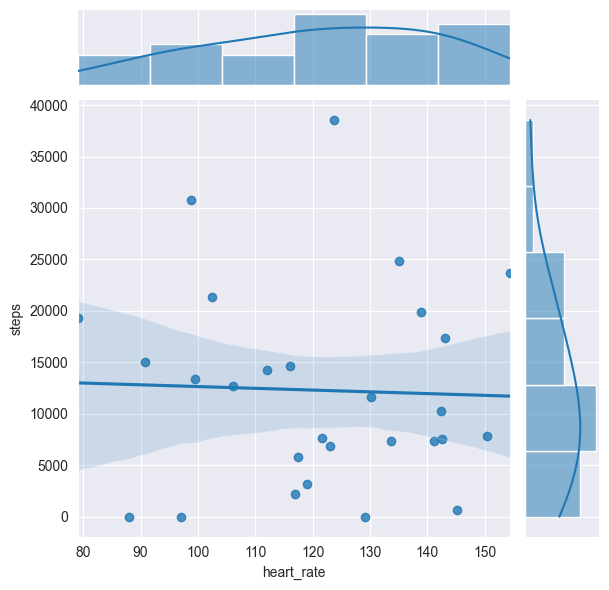

In [34]:
import seaborn as sns
# Setting Seaborn plot style
sns.set_style("darkgrid")

#Plotting our data
plot = sns.jointplot(x='heart_rate', y='steps', data=analysis_df_cleaned,
                    kind='reg')


As we can see from the scatterplot above, it looks like there might be a correlation there. Let's compute $R^2$ just to see exactly how correlated.

We'll follow [this documentation](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.linregress.html) and perform a linear regression to obtain the coefficient of determination ($R^2$).

In [35]:
from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(
      analysis_df_cleaned.get('heart_rate'), analysis_df_cleaned.get('steps'))

print(f'Slope: {slope:.3g}')
print(f'Coefficient of determination: {r_value**2:.3g}')
print(f'p-value: {p_value:.3g}')

Slope: -17.1
Coefficient of determination: 0.0013
p-value: 0.855


As the p value is less than 85.5%, it means that that our result is not statistically significant evidence to conclude that there is a correlation between average heart rate and the total number of steps in a day.

# 9. Outlier Detection

However, even though our p value does not seem to provide enough statistical significance that there is a correlation between average heart rate and the number of steps in a day, there might be outliers that do not follow any correlation. In this section of our analysis, we will find if there are outliers like that and if they exist, we will visually highlight them in our plot.

Before finding the individual outlier values, it would be interesting to see the summary of our step count and average heart rate parameters. It will give us a clear idea of what values are typical and which values can be considered atypical based on the data that we recieved from Google Fit.

In [36]:
analysis_df_cleaned_summary = analysis_df_cleaned.describe().get(
                                          ['steps','heart_rate'])
analysis_df_cleaned_summary

,steps,heart_rate
count,28.000000,28.000000
mean,12284.178571,121.332143
std,9645.407040,20.364313
min,0.000000,79.100000
25%,6598.250000,105.250000
50%,10953.000000,122.350000
75%,17842.750000,139.375000
max,38538.000000,154.400000


To locate the outliers we will be using a supervised as well as unsupervised algorithm called the Elliptic Envelope. In statistical studies, Elliptic Envelope created an imaginary elliptical area around a given dataset where values inside that imaginary area is considered to be normal data, and anything else is assumed to be outliers. It assumes that the given data follows a gaussian distribution.

"The main idea is to define the shape of the data and anomalies are those observations that lie far outside the shape. First a robust estimate of covariance of data is fitted into an ellipse around the central mode. Then, the Mahalanobis distance that is obtained from this estimate is used to define the threshold for determining outliers or anomalies." [(S. Shriram and E. Sivasankar ,2019, pp. 221-225)](https://ieeexplore.ieee.org/document/9004325)

In [37]:
from sklearn.covariance import EllipticEnvelope
import copy

# Sometimes EllipticEnvelope shows slicing based copy warnings
# The next line changes a setting that prevents the error from happening

pd.set_option('mode.chained_assignment', None)

#create the model, set the contamination as 0.25
EE_model = EllipticEnvelope(contamination = 0.25)

#implement the model on the data
outliers = EE_model.fit_predict(analysis_df_cleaned.get(
                                                    ["steps", "heart_rate"]))

#extract the labels
analysis_df_cleaned["outlier"] = copy.deepcopy(outliers)

#change the labels
# We use -1 to mark an outlier and +1 for an inliner
analysis_df_cleaned["outlier"] = analysis_df_cleaned["outlier"].apply(
                                    lambda x: str(-1) if x == -1 else str(1))

#extract the score
analysis_df_cleaned["EE_scores"] = EE_model.score_samples(
                            analysis_df_cleaned.get(["steps", "heart_rate"]))

#print the value counts for inlier and outliers
print(analysis_df_cleaned["outlier"].value_counts())

1     21
-1     7
Name: outlier, dtype: int64


Below we will replot the analysis_df_cleaned dataframe to see how the two new columns were applied to it!

In [38]:
analysis_df_cleaned.head()

,date,steps,heart_rate,outlier,EE_scores
0,1646179200000,6868,123.1,1,-0.164460
1,1646265600000,10247,142.4,1,-1.350831
2,1646352000000,19896,138.8,1,-4.081853
3,1646611200000,17366,143.1,1,-3.370280
4,1646784000000,14240,112.0,1,-0.651794


Now that we have labeled the outliers as -1, let's try to see which values of average heart rate and steps are being identified as outliers by our Elliptic Envelope Algorithm.

In [39]:
outlier_df = analysis_df_cleaned[analysis_df_cleaned.get('outlier')=='-1'].get(
    ['steps','heart_rate'])
outlier_df

,steps,heart_rate
5,30735,98.8
8,23679,154.4
16,24861,135.0
20,19273,79.1
22,0,97.0
23,38538,123.8
27,0,88.0


Sweet, now that we know that there were outliers in our dataset, let's try to visually see which pair of values are being identified as outliers using a plot. Highlighting these outliers in a bright red color will make it super easy for us to identify them in our plot.

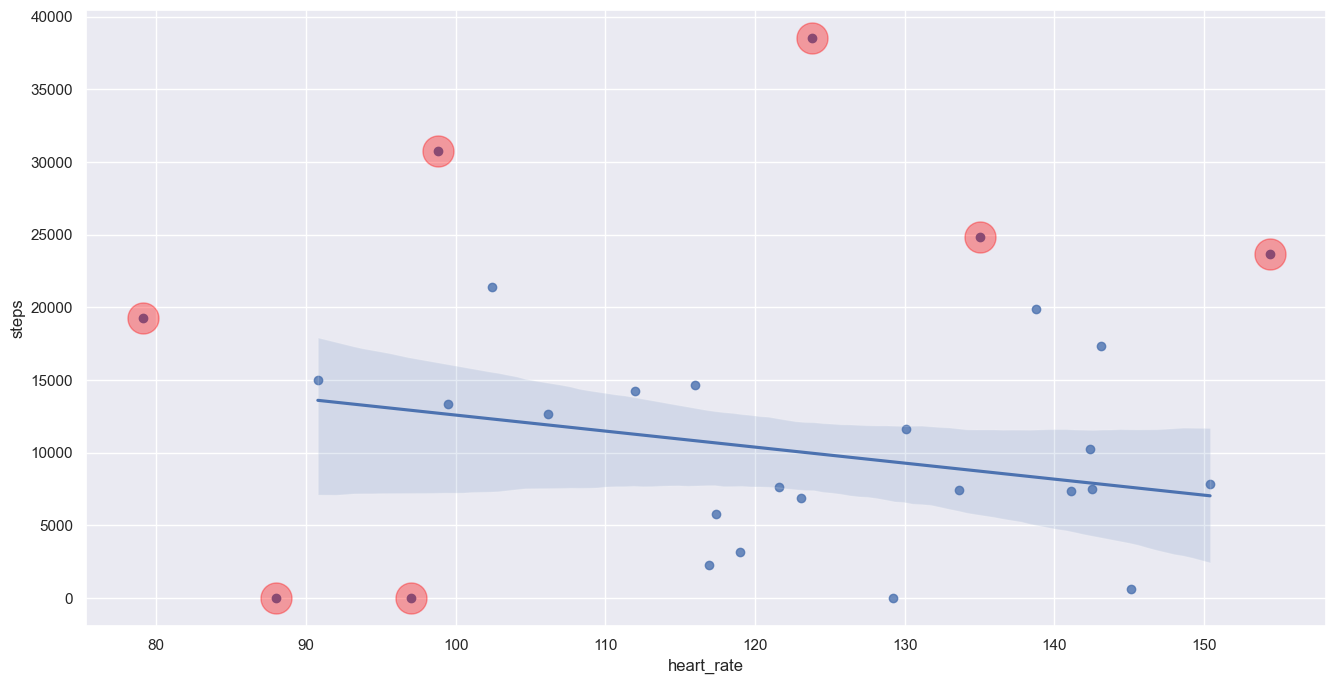

In [40]:
# Setting Figure Size in Seaborn
sns.set(rc={'figure.figsize':(16,8)})

# Setting Seaborn plot style
sns.set_style("darkgrid")

#Plotting our data
plot = sns.regplot(x='heart_rate', y='steps', data=analysis_df_cleaned.drop(
    outlier_df.index))

plt.scatter(outlier_df.get('heart_rate'),outlier_df.get('steps'))
plt.scatter(outlier_df.get('heart_rate'),outlier_df.get('steps'),
            facecolors='red',alpha=.35, s=500)

plt.show()

Thus, the points highlighted in red are ones that seem to not be following the general trend of our dataset. Lastly, let's see what the new p-value is after outlier removal!

In [41]:
slope, intercept, r_value, p_value, std_err = stats.linregress(
    analysis_df_cleaned.drop(outlier_df.index).get('heart_rate'),
     analysis_df_cleaned.drop(outlier_df.index).get('steps'))

print(f'Slope: {slope:.3g}')
print(f'Coefficient of determination: {r_value**2:.3g}')
print(f'p-value: {p_value:.3g}')

Slope: -110
Coefficient of determination: 0.0957
p-value: 0.172


Our new p-value after removing any outliers is 0.172 which is much closer to 5% than before. Therefore, after removing the outliers, our result is getting closer to being statistically significant but there is yet not enough evidence to imply that that there is a correlation between average heart rate and the total number of steps in a day.